# LING 530A Assignment 1
## Peter Sullivan

### Preface

While the Yelp dataset was available to be used for this assignment, I have instead chosen to use a dataset consisting of approximately ~300 Twitter users tweets (n=1 million) collected as part of an ongoing project. In addition I used [this word2vec tutorial](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial) the following resources were consulted in learning how to use word2vec as well as the [NLTK Book](https://www.nltk.org/book/) for general text processing techniques

## Text Extraction

The twitter data in question was written to different files across several different directories. Because twitter data is stored in JSON format, all we need to do is extract the full_text field from the JSON which I did here. I decided on saving the data in a pickle format for convenience. It could have just as easily been written to a text file.

In [ ]:
import pickle
import os
import sys
import json
import datetime
from ast import literal_eval
start_main_time = datetime.datetime.now()
dname = sys.argv[1]
wdir = os.getcwd()

dir = wdir + "/" + dname + "/"
files = os.listdir(dir)
full_texts = []

count = 0

for file in files:
    with open(dir + file, 'r', encoding='utf-8') as fp:
        print("trying file number: " + str(count) + " - " + dir + file)
        count += 1
        for line in fp:
            full_texts.append(json.loads(literal_eval(line))["full_text"])
outputfile = dname + "_extractedtext.pkl"
with open(outputfile, 'wb') as fp:
    pickle.dump(full_texts, fp)
print("Main Script Duration: {}".format(datetime.datetime.now() - start_main_time))

## Word Frequency

For the word frequencies, we simply need to load all of the words into a default dictionary structure and then count the instances of each occurance. Because we have not yet really preprocessed the data at this point, it reflects many common twitter words (ex: RT) or extremely common English words (ex: the, to, a), that may have little actual semantic information. This illustrates the importance of pre-processing the data to remove frequent words that would make semantic analysis difficult.

In [4]:
from collections import defaultdict
with open("fulltexts.pkl","rb") as fp:
    fulltexts = pickle.load(fp)

words = defaultdict(int)
for sentence in fulltexts:
    for word in sentence.split(" "):
        words[word] +=1
sorted_dict = sorted(words.items(), key=lambda kv:kv[1], reverse=True)
print(sorted_dict[0:19])



[('RT', 625040), ('the', 466324), ('to', 361573), ('a', 247059), ('of', 240324), ('and', 209697), ('is', 200775), ('', 193792), ('in', 175621), ('for', 146655), ('I', 123116), ('you', 118431), ('on', 98003), ('that', 97816), ('are', 94163), ('The', 75094), ('with', 72494), ('be', 70492), ('&amp;', 68010)]


## Pre-processing

We need to remove these common words and clean up our data and SpaCy provides easy tools to do so.

In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
import spacy  # For preprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M:%S', level=logging.INFO)


Once our libraries are loaded, we will load up Spacy, in addition we'll add "rt" as a stopword to get rid of the frequent occurence in this dataset.

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
#remember to add whatever words to spacy stoplist
nlp.vocab["rt"].is_stop = True

Much of this next section is based on [the gensim word2vec tutorial](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial) due to its focus on preprocessing data.  In essence, we do a quick pass to remove any non-alphanumeric tokens, then remove stopwords, short words, remove any instance where the text would have been completely removed due to the cleaning, and then tokenize. 

In [ ]:
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

brief_cleaning = (re.sub("https?:[A-Za-z1-9/.]+|[^A-Za-z']+", ' ', str(row)).lower() for row in full_texts)
t = time()
full_texts = []
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
sentences = [row.split() for row in df_clean['clean']]

df_clean = ''
txt = ''


## Tagged Word Statistics

We'll use NLTK to POS tag all of the sentences, Spacy, while seemingly quite good at POS tagging, simply took too long with the size of the dataset.

In [ ]:
tagged_sents = []

for sent in sentences:
    tagged_sents.append(nltk.pos_tag(sent))

In [1]:
import pickle
with open("tagg.pkl","rb") as fp:
    tagged_sents = pickle.load(fp)

### Random Words

In [5]:
from collections import defaultdict
words = defaultdict(int)
for sent in tagged_sents:
    for word in sent:
        words[word[0]] +=1

In [11]:
import random
from math import log

random_words = random.choices(list(words.keys()), k=100)

log_freqs = []
for wd in random_words:
    log_freqs.append(log(words[wd]))

<BarContainer object of 100 artists>

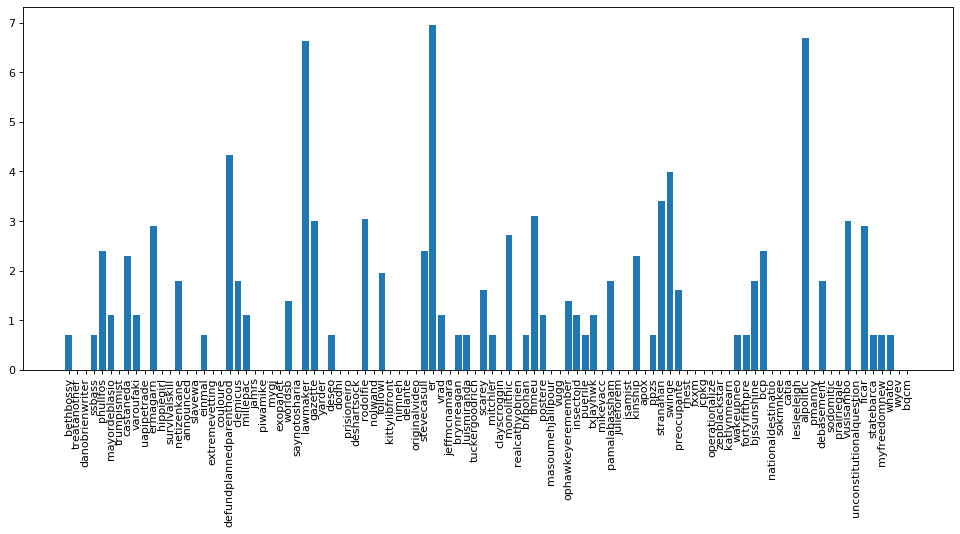

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80)
plt.xticks(rotation='vertical')
plt.bar(random_words,height=log_freqs)

### POS tags frequence

In [23]:
tags = defaultdict(int)
for sent in tagged_sents:
    for word in sent:
        tags[word[1]] +=1


<BarContainer object of 37 artists>

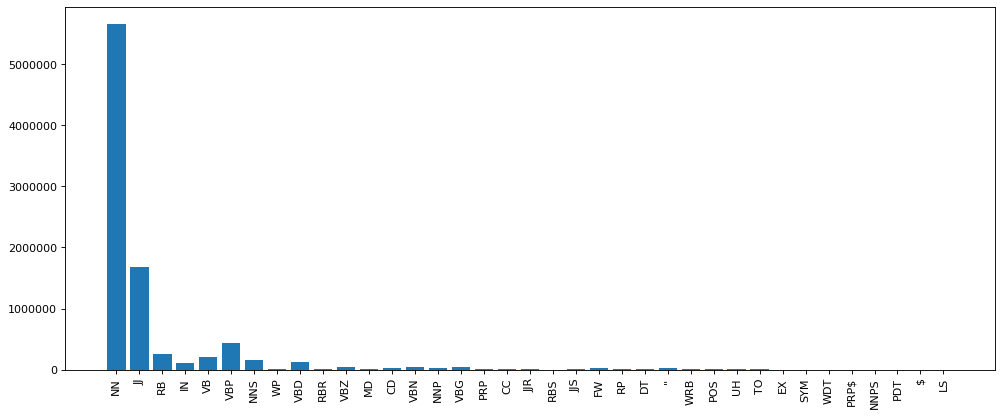

In [24]:
figure(num=None, figsize=(15, 6), dpi=80)
plt.xticks(rotation='vertical')
plt.bar(tags.keys(),height=tags.values())

### Adjective frequence

In [26]:
adjs = defaultdict(int)
for sent in tagged_sents:
    for word in sent:
        if word[1] =="JJ":
            adjs[word[0]] +=1
sorted_adjs = sorted(adjs.items(), key=lambda kv:kv[1], reverse=True)
print(sorted_adjs[0:19])

[('good', 24032), ('american', 22330), ('s', 20065), ('great', 19177), ('white', 19026), ('new', 18197), ('illegal', 13937), ('u', 12672), ('amp', 11751), ('liberal', 11038), ('right', 9899), ('big', 9880), ('real', 8896), ('follow', 8840), ('usa', 8606), ('bad', 8365), ('hillary', 8105), ('t', 7996), ('free', 7976)]


### Proper nouns frequence

In [27]:
nnps = defaultdict(int)
for sent in tagged_sents:
    for word in sent:
        if word[1] =="NNPS":
            nnps[word[0]] +=1
sorted_nnps = sorted(nnps.items(), key=lambda kv:kv[1], reverse=True)
print(sorted_nnps[0:19])

[('democrats', 28), ('know', 1), ('irs', 1), ('valley', 1), ('yr', 1), ('europeans', 1)]


Yikes. Looks like NLTK is not good at recognizing proper nouns. This may in part be due to also putting everything lowercase during our pre-processing.

## word2vec

### Training

One nice thing to do, prior to running w2v's training, is to run a bigram phrase identification model on the data. Gensim just happens to have something built in with the Phrases module, and we will use this to get a collection of all the phrases prior to training our w2v model.  

In terms of features for the model, we use a window size of ten based roughly on the average tweet length. Because we have millions of tweets and a vocabulary of ~240 million raw words, we can justify a model size of ~300 dimensions (an upper bound on the rule of thumb for setting it),

In [ ]:
#grab phrases
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

# run gensim
model = Word2Vec(size=300, window=10, min_count=100, workers=multiprocessing.cpu_count())
model.build_vocab(sentences, progress_per=10000)
model.train(sentences, total_examples=model.corpus_count, epochs=30, report_delay=1)
model.save("w2v.model")
end_main_time = datetime.datetime.now()
print("Main Script Duration: {}".format(end_main_time - start_main_time))

### word2vec Adjectives

For the adjectives we found before here are the most similar words associated:

In [31]:
from gensim.models import Word2Vec
model = Word2Vec.load("w2v_followers.model")
model.wv.most_similar("good", topn=3)

[('well', 0.5905184745788574),
 ('great', 0.5738784670829773),
 ('bad', 0.5057375431060791)]

In [32]:
model.wv.most_similar("american", topn=3)

[('america', 0.6221616268157959),
 ('american_citizen', 0.589103102684021),
 ('country', 0.540138304233551)]

In [33]:
model.wv.most_similar("s", topn=3)

[('isn_t', 0.4840695261955261),
 ('know', 0.4095908999443054),
 ('say', 0.38897907733917236)]

In [34]:
model.wv.most_similar("great", topn=3)

[('good', 0.5738784670829773),
 ('fantastic', 0.5682311058044434),
 ('awesome', 0.5602489709854126)]

In [35]:
model.wv.most_similar("white", topn=3)

[('white_people', 0.6483970284461975),
 ('non_white', 0.5436877608299255),
 ('black', 0.5252323746681213)]

In [36]:
model.wv.most_similar("new", topn=3)

[('late', 0.401083767414093),
 ('newly', 0.31115254759788513),
 ('boost', 0.30578941106796265)]

In [37]:
model.wv.most_similar("illegal", topn=3)

[('illegal_alien', 0.7390050888061523),
 ('illegal_immigrant', 0.7041549682617188),
 ('illegalalien', 0.5633381605148315)]

In [38]:
model.wv.most_similar("u", topn=3)

[('ur', 0.45698806643486023),
 ('ppl', 0.41990602016448975),
 ('n', 0.359674334526062)]

In [39]:
model.wv.most_similar("amp", topn=3)

[('w', 0.5693607330322266),
 ('continue', 0.44662171602249146),
 ('etc', 0.44407373666763306)]

In [40]:
model.wv.most_similar("liberal", topn=3)

[('leftist', 0.6220568418502808),
 ('left', 0.5661908984184265),
 ('libs', 0.519059956073761)]

In [41]:
model.wv.most_similar("right", topn=3)

[('constitutional_right', 0.49206653237342834),
 ('want', 0.435799241065979),
 ('mean', 0.4293100833892822)]

In [42]:
model.wv.most_similar("big", topn=3)

[('huge', 0.4910002648830414),
 ('major', 0.44849511981010437),
 ('yuge', 0.3808887004852295)]

In [43]:
model.wv.most_similar("real", topn=3)

[('actual', 0.4049798846244812),
 ('true', 0.3885716199874878),
 ('know', 0.38780972361564636)]

In [44]:
model.wv.most_similar("follow", topn=3)

[('fb', 0.5274211168289185),
 ('follow_patriot', 0.5161277055740356),
 ('follower', 0.5070836544036865)]

In [45]:
model.wv.most_similar("usa", topn=3)

[('america', 0.5759304165840149),
 ('country', 0.5161595344543457),
 ('nation', 0.4444349408149719)]

In [46]:
model.wv.most_similar("bad", topn=3)

[('good', 0.5057376027107239),
 ('well', 0.4635527729988098),
 ('terrible', 0.4422219395637512)]

In [47]:
model.wv.most_similar("hillary", topn=3)

[('hillary_clinton', 0.678663969039917),
 ('clinton', 0.6536428928375244),
 ('hrc', 0.6039748191833496)]

In [48]:
model.wv.most_similar("t", topn=3)

[('couldn_t', 0.3643495440483093),
 ('m', 0.35465720295906067),
 ('don_t', 0.3308106064796448)]

In [49]:
model.wv.most_similar("free", topn=3)

[('freely', 0.3489445745944977),
 ('pay', 0.3408348560333252),
 ('free_healthcare', 0.3396105170249939)]